# Medical Cost Pricing

### Student:Buruiana Iuliana-Maria


## Prezentarea setului de date

Setul de date "insurance.csv" contine 7 coloane si 1338 de randuri si reprezinta datele care afectează costurile medicale
ale unui beneficiar facturate de asigurarea de sanatate. 

## Caracteristici
<ul>
<li>age: Vârsta beneficiarului principal</li>
<li>sex: Sexul contractantului de asigurare, femeie, bărbat</li>
<li>bmi: Indicele de masă corporală, care oferă o înțelegere a corpului, greutăți care sunt relativ mari sau
mici în raport cu înălțimea,indice obiectiv al greutății corporale (kg / m ^ 2), folosind raportul dintre 
înălțime și greutate, în mod ideal între 18,5 și 24,9</li>

<li>children: Numărul de copii acoperiți de asigurarea de sănătate / Numărul de persoane aflate în întreținere</li>

<li>fumător: Beneficiarul este sau nu fumator</li>

<li>region: Zona de reședință a beneficiarului în SUA: nord-est, sud-est, sud-vest, nord-vest.</li>

<li>taxe: Costuri medicale individuale facturate de asigurarea de sănătate</li>
</ul>

## Etapele proiectului:

1. Importarea librariilor si crearea sesiunii spark
2. Importarea setului de date din fisierul CSV aflat in Google Drive
3. Prezentarea datelor (coloane, numar de intrari, cateva statistici)
4. Verificarea, prelucrarea si pregatirea datelor
5. Verificarea pe coloane a existentei valorilor null
<ul>
<li>Verificarea datelor din coloanele 'region' si 'smoker'</li>
<li>Transformarea variabilelor 'region' si 'smoker' de tip string in variabila categoriala</li>
<li>Creearea unui vector de 'features' folosind VectorAssembler</li>
</ul>
Selectia modelelor:
Linear Regression
Random Forest + creearea si utilizarea unui pipeline
Gradient-boosted tree regression + creearea si utilizarea unui pipeline
Utilizarea unui model DL - utilizand Tensorflow

In [1]:
from time import time
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions
import pyspark.sql.functions as f
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.model_selection import train_test_split
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

## 2. Incărcarea datelor

In [7]:
spark = SparkSession.builder.appName('StrokePrediction').getOrCreate()
df = spark.read.csv('insurance.csv', inferSchema=True, header=True)


## 3. Prezentarea datelor
Se vor afișa: schema datelor, numarul de intrari din setul de date, coloanele existente, afisare aprimelor 20 de intrari, o statistica si cateva ploturi (matricea de corelatii si histograme). Primulplot reprezinta  matricea de corelatii si va contine toate atributele din setul de date, al doilea plot va fi o histograma ce va prezenta distributia variabilei 'charges'.


In [8]:
# Se afiseaza schema datelor
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



Spark nu detectează schema în mod corespunzător, așa că trebuie să definim și schema pentru setul de date.
Tipul de date incorect poate produce probleme greu de depistat și erori de execuție. Prin urmare, se redifiește schema setului.

In [9]:
Schema=StructType([
  StructField('age',IntegerType(),nullable=True),
  StructField('sex',StringType() ,nullable=True),
  StructField('bmi',DoubleType(),nullable=True),
  StructField('children', IntegerType(),nullable=True),
  StructField('smoker',StringType() ,nullable=True),
  StructField('region',StringType() ,nullable=True),
  StructField('charges',DoubleType() ,nullable=True),
    
 
])
df = spark.read.option('header',True).schema(Schema).csv('insurance.csv')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [10]:
# Se afiseaza numarul de intrari din setul de date
df.count()

1338

In [11]:
# Se afiseaza coloanele din setul de date
df.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [12]:
# Se afiseaza datele (primele 20 de randuri)
df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [13]:
#Statistica asupra setului de date
df.summary().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    25%|                27|  null|             26.29|                0|  null|     null|         4738.2682|
|    50%|                39|  null|              30.4|                1|  null|     null|         9377.9047|
|    75%|          

In [14]:
# Se face transformarea dataframe-ului in Pandas pentru a putea crea plot-uri
df_pandas = df.toPandas()

<AxesSubplot:>

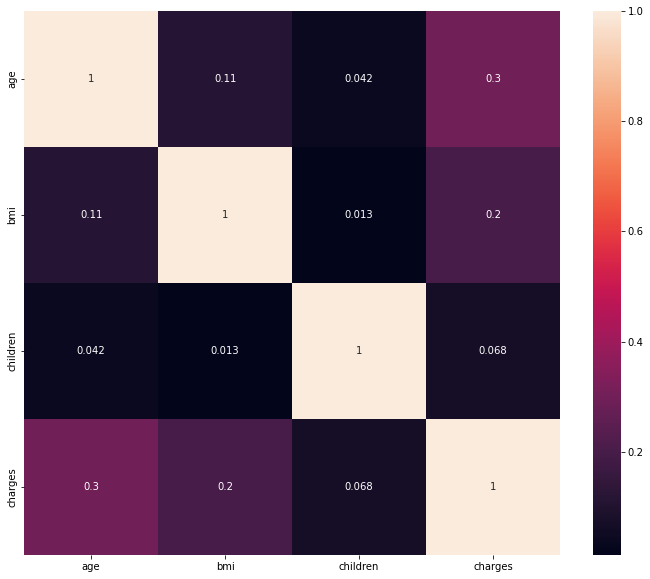

In [15]:
# Se afiseaza matricea de corelatii

plt.figure(figsize=(12,10))
sns.heatmap(df_pandas.corr(),annot=True)

<AxesSubplot:xlabel='charges', ylabel='Count'>

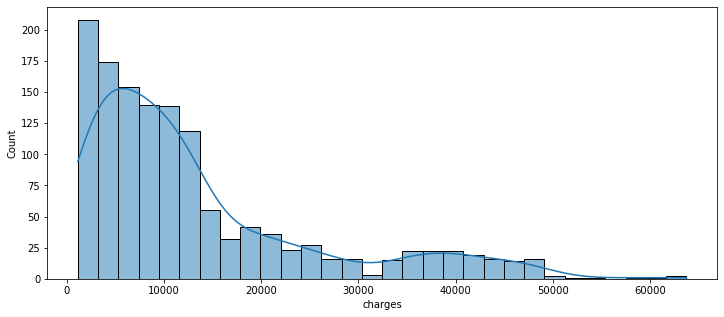

In [16]:
# Histograma pentru distributia coloanei 'charges'

plt.figure(figsize=(12, 5))
sns.histplot(df_pandas['charges'], kde=True)

## 4.Verificarea si prelucrarea datelor

Se verifica fiecare coloana ramasa pentru a vedea daca exista valori null. De asemenea, se afiseaza valorile din coloanele 'region', 'smoker' si 'sex' si se ia o decizie asupra modului in care vor fi utilizate datele pe care le contin. Se va folosi StringIndexer pentru transformarea in variabile categoriale, variabilele string 'smoker', 'region', 'sex' si se va crea un vector denumit "features", format din coloanele relevante, folosind VectorAssembler.

In [17]:
# Se verifica daca exista valori null si se afiseaza cate valori null sunt pentru fiecare coloana

df_agg= df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
df_agg.show()

+---+---+---+--------+------+------+-------+
|age|sex|bmi|children|smoker|region|charges|
+---+---+---+--------+------+------+-------+
|  0|  0|  0|       0|     0|     0|      0|
+---+---+---+--------+------+------+-------+



Se observa ca nu sunt valori null, deci nu trebuie sterse intrari din setul de date, sau inlocuite in vreun fel datele din coloana respectiva.

In [18]:
# Se obtine numarul de valori pentru coloana region
df2 = df.groupBy('region').count()
df2.orderBy(col("count").desc(),col("region").asc()).show(60)

# Se obtine numarul de valori pentru coloana smoker
df2 = df.groupBy('smoker').count()
df2.orderBy(col("count").desc(),col("smoker").asc()).show(60)

# Se obtine numarul de valori pentru coloana sex
df2 = df.groupBy('smoker').count()
df2.orderBy(col("count").desc(),col("smoker").asc()).show(60)


+---------+-----+
|   region|count|
+---------+-----+
|southeast|  364|
|northwest|  325|
|southwest|  325|
|northeast|  324|
+---------+-----+

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



Varaibilele  region, sex si smoker fiind de tip string vor trebui transformate in variabile categoriale pentru a putea fi utilizata mai departe.

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Crearea unui obiect StringIndexer, specificarea coloanelor de intrare și ieșire
SI_smoker = StringIndexer(inputCol='smoker',outputCol='smoker_cat')
SI_region = StringIndexer(inputCol='region',outputCol='region_cat')
SI_sex = StringIndexer(inputCol='sex',outputCol='sex_cat')

# Transformarea datelor
df = SI_smoker.fit(df).transform(df)
df = SI_region.fit(df).transform(df)
df = SI_sex.fit(df).transform(df)
# Afișarea datelor transformate
df.select('smoker', 'smoker_cat', 'region', 'region_cat', 'sex', 'sex_cat').show(10)



+------+----------+---------+----------+------+-------+
|smoker|smoker_cat|   region|region_cat|   sex|sex_cat|
+------+----------+---------+----------+------+-------+
|   yes|       1.0|southwest|       2.0|female|    1.0|
|    no|       0.0|southeast|       0.0|  male|    0.0|
|    no|       0.0|southeast|       0.0|  male|    0.0|
|    no|       0.0|northwest|       1.0|  male|    0.0|
|    no|       0.0|northwest|       1.0|  male|    0.0|
|    no|       0.0|southeast|       0.0|female|    1.0|
|    no|       0.0|southeast|       0.0|female|    1.0|
|    no|       0.0|northwest|       1.0|female|    1.0|
|    no|       0.0|northeast|       3.0|  male|    0.0|
|    no|       0.0|northwest|       1.0|female|    1.0|
+------+----------+---------+----------+------+-------+
only showing top 10 rows



In [20]:
# crearea obiectului si specificarea coloanelor de intrare si iesire
OHE = OneHotEncoder(inputCols=['smoker_cat', 'region_cat', 'sex_cat'],outputCols=['smoker_OHE', 'region_OHE', 'sex_OHE'])

# transformarea datelor
df = OHE.fit(df).transform(df)

# vizualizarea si transformarea datelor
df.select('smoker', 'smoker_cat', 'smoker_OHE', 'region', 'region_cat', 'region_OHE', 'sex', 'sex_cat', 'sex_OHE').show(10)


+------+----------+-------------+---------+----------+-------------+------+-------+-------------+
|smoker|smoker_cat|   smoker_OHE|   region|region_cat|   region_OHE|   sex|sex_cat|      sex_OHE|
+------+----------+-------------+---------+----------+-------------+------+-------+-------------+
|   yes|       1.0|    (1,[],[])|southwest|       2.0|(3,[2],[1.0])|female|    1.0|    (1,[],[])|
|    no|       0.0|(1,[0],[1.0])|southeast|       0.0|(3,[0],[1.0])|  male|    0.0|(1,[0],[1.0])|
|    no|       0.0|(1,[0],[1.0])|southeast|       0.0|(3,[0],[1.0])|  male|    0.0|(1,[0],[1.0])|
|    no|       0.0|(1,[0],[1.0])|northwest|       1.0|(3,[1],[1.0])|  male|    0.0|(1,[0],[1.0])|
|    no|       0.0|(1,[0],[1.0])|northwest|       1.0|(3,[1],[1.0])|  male|    0.0|(1,[0],[1.0])|
|    no|       0.0|(1,[0],[1.0])|southeast|       0.0|(3,[0],[1.0])|female|    1.0|    (1,[],[])|
|    no|       0.0|(1,[0],[1.0])|southeast|       0.0|(3,[0],[1.0])|female|    1.0|    (1,[],[])|
|    no|       0.0|(

Mai departe se va forma un vector 'features' utilizand coloanele relevante. Vor fi incluse  toate atributele numerice, deoarece, conform matricei de corelatie, nu se poate spune ca existau valori ce ar fi fost mult mai reprezentative decat altele in relatie cu variabila 'charges'.

In [21]:
#Se va forma un vector denumit "features", format din coloanele relevante. 

assembler = VectorAssembler(
  inputCols=['age',
              'bmi',
              'children',
             'region_cat',
             'smoker_cat',
             'region_OHE',
             'smoker_OHE', 
             'sex_cat',
             'sex_OHE'
            ],
         outputCol="features")


# se completeaza valorile null
df = df.fillna(0)

# se transforma datele
output = assembler.transform(df)

# afisarea vectorului transformat
output.select("features", "charges").show()


+--------------------+-----------+
|            features|    charges|
+--------------------+-----------+
|(11,[0,1,3,4,7,9]...|  16884.924|
|(11,[0,1,2,5,8,10...|  1725.5523|
|(11,[0,1,2,5,8,10...|   4449.462|
|(11,[0,1,3,6,8,10...|21984.47061|
|(11,[0,1,3,6,8,10...|  3866.8552|
|(11,[0,1,5,8,9],[...|  3756.6216|
|(11,[0,1,2,5,8,9]...|  8240.5896|
|[37.0,27.74,3.0,1...|  7281.5056|
|(11,[0,1,2,3,8,10...|  6406.4107|
|(11,[0,1,3,6,8,9]...|28923.13692|
|(11,[0,1,3,8,10],...|  2721.3208|
|(11,[0,1,4,5,9],[...| 27808.7251|
|(11,[0,1,3,7,8,10...|   1826.843|
|(11,[0,1,5,8,9],[...| 11090.7178|
|(11,[0,1,4,5,10],...| 39611.7577|
|[19.0,24.6,1.0,2....|   1837.237|
|(11,[0,1,2,3,8,9]...| 10797.3362|
|(11,[0,1,3,8,10],...| 2395.17155|
|(11,[0,1,3,7,8,10...|  10602.385|
|(11,[0,1,3,4,7,10...|  36837.467|
+--------------------+-----------+
only showing top 20 rows



## 5. Alegerea și implementarea modelelor

Folosind setul de date ales, se doreste prezicerea costurilor medicale acoperita de asigurarea de sanatate a beneficiarilor in functie de anumite caracteristici. Pentru rezolvare, se vor folosi 3 modele ML. Deoarece problema pusa  este  de regresie, modelele ML alese si implementate vor fi de tip regresie.

1. Regresie Liniara

Primul pas va fi crearea unui data frame pentru regresie, folosid doar coloanele 'features' si 'charges' apoi se va face o diviziune asupra setului de date. Datele din setul de date vor fi impartite in doua subseturi: unul pentru antrenarea modelului si unul pentru testarea lui, procentele utilizate la impartire fiind 70% pentru cel de antrenare si 30% pentru cel de testare. Se va crea apoi un 
obiect de tip Linear Regresion, se antreneaza modelul si se testeaza.

2. Random Forest

Pentru acest model s-a creat un vector nou, numit 'features2'. Se creeaza un data frame nou, utilizand 'charges' si 'features2' si se imparte  setul de date in date de antrenare si date de testare, folosind procentul 70% pentru datele de antrenare si 30% pentru cele de testare. Se creeaza un obiect de tip Random Forest Regressor cu coloanele 'charges' si 'features2' si un pipeline. Se antreneaza modelul utilizand pipeline-ul creat, apoi se testeaza si se evalueaza rezultatul obtinut.

3. Gradient-boosted tree regression

Pentru acest model se va folosi acelasi vector de features creat pentru Random Forest,  anume 'features2', si aceleasi seturi de date de antrenament si de testare. Primul pas este crearea un obiect de tipul GBTRegressor si un nou pipeline, la pasul doi se antreneaza modelul folosind pipeline-ul. Se fac predictii pe baza setului de date de test, utilizand modelul antrenat si se evalueaza predictiile.

#### 5.1 Linear Regression

In [22]:
# Se creeaza un dataframe doar cu aceste 2 coloane

df_linear_regression = output.select("features", "charges")

In [23]:
# Se face o diviziune a setului de date în subseturi pentru antrenare si testare testare. Procentele vor fi 70%, respectiv 30%.
trainData,testData = df_linear_regression.randomSplit([0.7,0.3])

In [24]:
#Se afiseaza statistici asupra datelor pentru training
trainData.describe().show()

+-------+------------------+
|summary|           charges|
+-------+------------------+
|  count|               935|
|   mean|13243.231118278076|
| stddev|12367.281649684883|
|    min|         1121.8739|
|    max|       63770.42801|
+-------+------------------+



In [25]:
#Se afiseaza statistici asupra datelor pentru test
testData.describe().show()

+-------+------------------+
|summary|           charges|
+-------+------------------+
|  count|               403|
|   mean|13333.508424736969|
| stddev|11505.671134340035|
|    min|         1163.4627|
|    max|       55135.40209|
+-------+------------------+



In [26]:
# Se creeaza un obiect de tip LinearRegression
lr = LinearRegression(labelCol='charges')

In [27]:
# Se antreneaza modelul
lrModel = lr.fit(trainData)

In [28]:
# Se afiseaza coeficientii si interceptia pentru regresia liniara
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [270.11152620913185,329.5713468438745,530.0190240632434,177.2767396421288,12205.015622722352,-251.6445033019465,215.8768703956481,-821.8871004269586,-12205.015622722536,73.91570634420495,-73.91570634436678] Intercept: -712.7331915691593


In [29]:
#Se evalueaza modelul pe datele de testare
results = lrModel.evaluate(testData)

In [30]:
# Se afiseaza informatiile obtinute dupa evaluare 
print("RMSE: {}".format(results.rootMeanSquaredError))
print("MSE: {}".format(results.meanSquaredError))
print("R2: {}".format(results.r2))

RMSE: 6100.115803046181
MSE: 37211412.81057376
R2: 0.71820632600281


In [31]:
# Se afiseaza valorile reziduale
results.residuals.show()

+-------------------+
|          residuals|
+-------------------+
|  5370.120137146012|
|-11587.021087074627|
|-10532.034798612447|
|-10582.219569837496|
|-10741.075950556668|
|-10414.944294257544|
|  5417.395519547019|
|  5288.150218687806|
|-10731.391734042827|
|  7053.840234060168|
|-440.95390255170605|
| 19451.278100791722|
| -881.3102771447448|
| 11203.797097357181|
| 19492.614375859142|
|  2029.336335687277|
| 14158.087225557605|
| 1546.6809754123115|
|  659.1845866348913|
|  503.2984468840541|
+-------------------+
only showing top 20 rows



In [32]:
# Sa se afiseze corelatia intre 'charges' si 'age'
from pyspark.sql.functions import corr
df.select(corr('charges','age')).show()

+------------------+
|corr(charges, age)|
+------------------+
| 0.299008193330648|
+------------------+



In [33]:
# Sa se afiseze corelatia intre 'charges' si 'children'
from pyspark.sql.functions import corr
df.select(corr('charges','children')).show()

+-----------------------+
|corr(charges, children)|
+-----------------------+
|    0.06799822684790494|
+-----------------------+



In [34]:
# Sa se afiseze corelatia intre 'charges' si 'bmi'
from pyspark.sql.functions import corr
df.select(corr('charges','bmi')).show()

+-------------------+
| corr(charges, bmi)|
+-------------------+
|0.19834096883362906|
+-------------------+



In [35]:
#Aplicarea modelului pe datele de test neetichetate
unlabeled_data=testData.select("features")
predictions = lrModel.transform(unlabeled_data)
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|(11,[0,1,2,3,4,9]...|32331.756662853986|
|(11,[0,1,2,3,4,9]...|31181.830737074626|
|(11,[0,1,2,3,4,9]...| 33933.34054861245|
|(11,[0,1,2,3,4,9]...|  35455.6044698375|
|(11,[0,1,2,3,4,10...|23570.531050556667|
|(11,[0,1,2,3,4,10...|32876.988044257545|
|(11,[0,1,2,3,4,10...| 35616.82588045298|
|(11,[0,1,2,3,4,10...|36630.946781312196|
|(11,[0,1,2,3,4,10...| 35601.22853404283|
|(11,[0,1,2,3,4,10...|41495.338115939834|
|(11,[0,1,2,3,8,9]...| 5002.142402551706|
|(11,[0,1,2,3,8,9]...|2944.4661392082776|
|(11,[0,1,2,3,8,9]...| 5445.501727144745|
|(11,[0,1,2,3,8,9]...| 5592.614842642821|
|(11,[0,1,2,3,8,9]...|  3796.31402414086|
|(11,[0,1,2,3,8,9]...| 4723.701664312723|
|(11,[0,1,2,3,8,9]...|10756.959034442394|
|(11,[0,1,2,3,8,9]...| 5587.221524587689|
|(11,[0,1,2,3,8,9]...| 7326.630413365108|
|(11,[0,1,2,3,8,9]...| 7483.176803115946|
+--------------------+------------

In [36]:
testData.show()

+--------------------+-----------+
|            features|    charges|
+--------------------+-----------+
|(11,[0,1,2,3,4,9]...| 37701.8768|
|(11,[0,1,2,3,4,9]...|19594.80965|
|(11,[0,1,2,3,4,9]...|23401.30575|
|(11,[0,1,2,3,4,9]...| 24873.3849|
|(11,[0,1,2,3,4,10...| 12829.4551|
|(11,[0,1,2,3,4,10...|22462.04375|
|(11,[0,1,2,3,4,10...| 41034.2214|
|(11,[0,1,2,3,4,10...|  41919.097|
|(11,[0,1,2,3,4,10...| 24869.8368|
|(11,[0,1,2,3,4,10...|48549.17835|
|(11,[0,1,2,3,8,9]...|  4561.1885|
|(11,[0,1,2,3,8,9]...|22395.74424|
|(11,[0,1,2,3,8,9]...| 4564.19145|
|(11,[0,1,2,3,8,9]...|16796.41194|
|(11,[0,1,2,3,8,9]...| 23288.9284|
|(11,[0,1,2,3,8,9]...|   6753.038|
|(11,[0,1,2,3,8,9]...|24915.04626|
|(11,[0,1,2,3,8,9]...|  7133.9025|
|(11,[0,1,2,3,8,9]...|   7985.815|
|(11,[0,1,2,3,8,9]...| 7986.47525|
+--------------------+-----------+
only showing top 20 rows



## 5.2 Random Forest

In [38]:
#Se creeaza un nou vector, numit 'features2'

assembler = VectorAssembler(
  inputCols=['age',
              'bmi',
              'children',
             'region_cat',
             'smoker_cat',
             'sex_cat',
             'region_OHE',
             'smoker_OHE',
             'sex_OHE',
            
            ],
         outputCol="features2")

output2 = assembler.transform(df)

In [39]:
# Se creeaza un data frame nou

df_RandomForest = output2.select("features2", "charges")

In [40]:
# Se imparte  setul de date in date de antrenare si date de test, cu procente 70% si 30%

trainData,testData = df_RandomForest.randomSplit([0.7,0.3])

In [41]:
#Se afiseaza statistici asupra datelor pentru training

trainData.describe().show()

+-------+-----------------+
|summary|          charges|
+-------+-----------------+
|  count|              917|
|   mean|13131.53913172303|
| stddev|12047.26469417141|
|    min|        1121.8739|
|    max|      63770.42801|
+-------+-----------------+



In [42]:
#Se afiseaza statistici asupra datelor pentru test

testData.describe().show()

+-------+------------------+
|summary|           charges|
+-------+------------------+
|  count|               421|
|   mean| 13572.93018282423|
| stddev|12254.532155507519|
|    min|         1131.5066|
|    max|        48673.5588|
+-------+------------------+



In [43]:
# Se creeaza un obiect de tip Random Forest Regressor cu coloanele 'charges' si 'features2'

rf = RandomForestRegressor(labelCol = 'charges',
                            featuresCol = 'features2')

In [44]:
featureIndexer =\
    VectorIndexer(inputCol="features2", outputCol="indexedFeatures").fit(trainData)

pipeline = Pipeline(stages=[featureIndexer, rf])

In [45]:
# Se antreneaza modelul

model = pipeline.fit(trainData)

In [46]:
# Se testeaza si se evalueaza modelul

predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="charges", predictionCol="prediction", metricName="mae")

mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)

rfModel = model.stages[1]
print(rfModel)

MAE on test data = 2645.61
RandomForestRegressionModel: uid=RandomForestRegressor_109e2619e56b, numTrees=20, numFeatures=11


## 6. Utilizarea unui model DL

Modelul DL va fi de tip regresie si va avea ca scop rezolvarea aceleiasi probleme: prezicerea costurilor medicale individuale facturate de asigurarea de sănătate. Pentru acesta se va folosi un data frame de tip pandas din care se vor sterge variabilele de tip string ('region','smoker', 'sex') si se vor separa caracteristicile variabilei tinta ('charges'), apoi se vor imparti datele in date de antrenare si date de testare. Se va aplica un feature scaling; acesta va invata pe datele de antrenare si va fi aplicat pe datele de antrenament si de test. Apoi se va crea o retea neuronala cu o arhitectura adaptata problemelor de tip regresie si se va compila modelul, avand parametrii de pe ultimul strat luati in calcul, aceasta fiind o problema de regresie si nu de clasificare. Se antreneaza modelul pentru 200 de epoci si o dimensiune a batch-ului de 128. La final, se va folosi un grafic pentru a analiza training loss-ul si validation loss-ul si se vor afisa valorile RMSE, MAE si MSLE.

In [47]:
# Se transforma data frame-ul intr-un dat frame de tip pandas
dfdl = df.toPandas()

# Se scoate coloana 'smoker' si coloana 'region' pentru a fi suprimate
dfdl = dfdl.drop('smoker', axis = 1)
dfdl = dfdl.drop('region', axis = 1)
dfdl = dfdl.drop('sex', axis = 1)
dfdl = dfdl.drop('smoker_OHE', axis = 1)
dfdl = dfdl.drop('region_OHE', axis = 1)
dfdl = dfdl.drop('sex_OHE', axis = 1)
# Se separa caracteristicile variabilei 'popularity'
X = dfdl.drop('charges', axis = 1)
y = dfdl['charges']

# Se impart datele in date de antrenare si date de testare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train)

     age     bmi  children  smoker_cat  region_cat  sex_cat
405   52  38.380         2         0.0         3.0      1.0
835   42  35.970         2         0.0         0.0      0.0
483   51  39.500         1         0.0         2.0      1.0
319   32  37.335         1         0.0         3.0      0.0
956   54  30.800         1         1.0         0.0      0.0
..   ...     ...       ...         ...         ...      ...
575   58  27.170         0         0.0         1.0      1.0
973   19  40.500         0         0.0         2.0      1.0
75    57  34.010         0         0.0         1.0      0.0
599   52  37.525         2         0.0         1.0      1.0
863   36  19.855         0         0.0         3.0      1.0

[936 rows x 6 columns]


In [48]:
# feature scaling
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Se afiseaza forma dataset-urilor de antrenament si de testare

print(X_train.shape)
print(X_test.shape)

(936, 6)
(402, 6)


In [54]:
# Se creeaza o retea neuronala ce are o arhitectura potrivita unei probleme de tip regresie
model = Sequential()
model.add(Dense(6, activation='relu', input_shape=(6, )))
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6)                 42        
                                                                 
 dense_6 (Dense)             (None, 6)                 42        
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
 dense_8 (Dense)             (None, 6)                 42        
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Se compileaza modelul 

model.compile(optimizer='adam', loss='mse')

In [56]:
# Se antreneaza modelul pentru 200 de epoci si o dimensiune a batch-ului de 128.

history = model.fit(x=X_train,
                  y=y_train,
                  validation_data=(X_test, y_test),
                  batch_size=128, 
                  epochs=200)

Epoch 1/200
8/8 [==============================] - 1s 26ms/step - loss: 330293184.0000 - val_loss: 304835616.0000
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 330291328.0000 - val_loss: 304833760.0000
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 330289216.0000 - val_loss: 304831584.0000
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 330286944.0000 - val_loss: 304829216.0000
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 330284352.0000 - val_loss: 304826624.0000
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 330281536.0000 - val_loss: 304823712.0000
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 330278368.0000 - val_loss: 304820416.0000
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 330274784.0000 - val_loss: 304816704.0000
Epoch 9/200
8/8 [==============================] - 0s 6ms/step - loss: 330270624.0000 - val_los

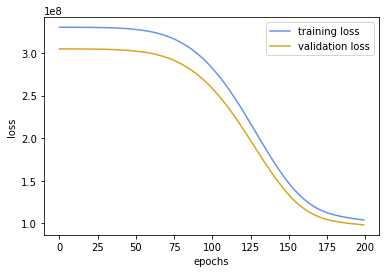

In [79]:
# Se analizeaza pe grafic training loss-ul si validation loss-ul

plt.plot(history.history['loss'], c='cornflowerblue', label='training loss')
plt.plot(history.history['val_loss'], c='goldenrod', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss');

In [57]:
# Calcularea si afisarea valorilor RMSE, MAE, MSLE
from sklearn.metrics import mean_squared_log_error
y_pred = model.predict(X_test).reshape((-1, ))
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
msle = mean_squared_log_error(y_test, y_pred)
print(f'RMSE: {rmse} - MAE: {mae} - MSLE: {msle}')

13/13 [==============================] - 0s 1ms/step
RMSE: 10192.021681607994 - MAE: 7857.906569790888 - MSLE: 0.7486421148908423


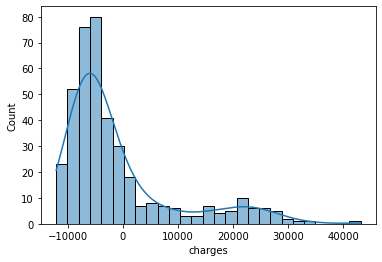

In [58]:
# Se calculeaza vectorul de valori reziduale (valori reale - predictii)  
errors = y_test - y_pred

# Histograma cu estimarea densitatii acestor erori.
sns.histplot(x=errors, kde=True);